### Train YOLO V1

* 정의한 DarkNet에 이미지를 입력하여 7 * 7 * 30 크기의 feature map을 loss function을 통해 학습
* detection 시에는 최종 예측 결과에 Non Maximum Suppression 알고리즘 사용
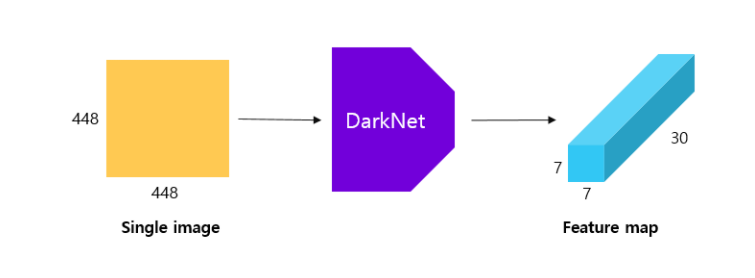

In [ ]:
import torch
import torch.nn as nn

### architecture_config(DarkNet)

* (kernel_size, num_filters, stride, padding)이 튜플 형식으로 저장

* "M"은 maxpooling을 의미함.

* 마지막 리스트 요소는 마지막 정수값 만큼 반복함을 의미

* 리스트 요소의 자료형에 따라 layer을 추가하여 모델을 설계

* 문자열 그러니까 "M"인경우는  max pooling, 튜플일경우 해당 하이퍼파라미터에 맞는 conv layer를, 리스트일 경우는 그만큼 layer 반복해 줌. 즉 type(문자형)에 따라서 어떤 행동을 할지 결정

In [ ]:
architecture_config = [
    (7, 64, 2, 3),
    "M"
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

### torch.nn
* torch.nn 패키지를 통해 신경망을 생성
* nn은 모델을 정의하고 미분하는데 torch.autograd를 사용
* 여기서 torch.autograd는 pytorch의 자동 미분 엔진(순전파, 역전파)
* nn은 모델 만드는데 기초함수 같음

### nn.Conv2d
* nn.Conv2d는 3가지 파라미터를 사용함.
* in_channels, out_channels, kernel_size를 입력받음
* input 값에 2d colvolution을 적용하는 함수
* (N, C, H, W)로 입출력함, N은 batch size, C는 채널 수, H와 W는 높이와 너비를 뜻함.
* default는 bias=True인데 여기서는 False로 설정함.
* https://gaussian37.github.io/dl-pytorch-conv2d/

### nn.BatchNorm2d
* 배치 정규화 함수
* 일반적으로 경사하강법을 사용할 때 한꺼번에 너무 많은 데이터를 처리하지 못하기 때문에 batch 단위로 나눠서 학습함. 그래서 일부의 데이터(batch size)만큼만 사용하는 SGD(stochastic gradient descent)를 사용함. 이때, 학습 데이터 전체를 한번 학습하는 것을 Epoch라고 하고 Gradient를 구하는 단위를 Batch라고 한다.
* 이때 Batch 단위로 학습하면 Internal Covariant Shift(내부 공변량 변화?)라는 문제가 발생하기 때문에, 배치 정규화를 통해서 해결.
* 배치별로 평균과 분산을 이용해 정규화 하는 것.
* https://gaussian37.github.io/dl-concept-batchnorm/

### nn.LeakyReLU
* 활성화 함수
* 활성화 함수를 사용하는 이유는 XOR 문제에서 출발함. 초창기의 퍼셉트론은 AND와 OR은 해결할 수 있었지만, XOR을 해결하지 못했는데 이 때문에 hidden layer을 통해서 해결함. 하지만, hidden layer을 무작정 쌓아도 선형분류기를 비선형 분류기로 바꿀수가 없음. 왜냐하면 아무리 많은 선형 분류기가 있어도 y= ax+b의 성질 때문에 하나의 식으로 나타낼 수 있기 때문에 깊은 layer을 구현하지 못함.
* 즉, 선형 연산을 하는 layer을 수 십개 쌓아도 하나의 선형 연산으로 나타낼 수 있다.
* 이를 해결하기 위해 활성화 함수를 통해서 비선형 방식으로 출력값을 도출함.\


* input 값이 음수일때 기울기가 0.01으로 ReLu보다는 학습이 더 잘된다.
* LeakyReLU(x)=max(0,x)+negative_slope∗min(0,x)
* https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html

### def forward(self, x):
* forward pass
* 순전파랑 차이점?
* https://ko.d2l.ai/chapter_deep-learning-basics/backprop.html
* CNNBlock에 있는 것을 순서대로(Conv2d -> 정규화 -> 활성화 함수)


In [ ]:
# torch.nn.Module을 상속받는 파이썬 클래스
# conv layer 다음 배치 정규화 relu 순으로 이루어짐.
class CNNBlock(nn.Module): 
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        #컨볼루션 커널 정의, in_channel과 out_channel로 입력받은 것들을 기준으로
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        #기울기 소실이나 발산 등의 문제로 정규화를 거쳐줌
        self.batchnorm = nn.BatchNorm2d(out_channels)
        #렐루함수
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

#### Yolov1의 기본적인 구성


In [ ]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        #darknet을 만드는 과정?
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))
    

###  def _create_conv_layers(self, architecture):
* self.darknet = self._create_conv_layers(self.architecture)을 통해 Darknet을 만드는 것 같음
* self.architecture를 통해 앞에서 구조를 정의함
* 앞에서 정의한 CNNBlock 사용


* list로 선언된 architecture의 type를 통해 layer를 쌓음.
* tuple일 경우에는 해당 하이퍼 파라미터에 맞는 conv layer를, str일 경우에는 max pooling을, list일 경우에는 그만큼 layer을 반복해줌

#### nn.MaxPool2d
* pooling이란 간단히 말하면 특징을 뽑아내는 과정
* conv layer에서 filter를 통해 이미지의 feature을 계산 -> 계산 결과를 활성화 함수로 정리 -> 이후 계산결과를 pooling해주는 과정


* Pooling은 input size를 줄여서 텐서의 크기를 줄이고, 오버피팅을 조절함. 특징을 잘 뽑아낼 수 있다는 장점이 있음.
* 여기서는 2*2의 크기를 가짐. 

#### Padding과Stride
* stirde는 filter를 이동하는 간격
* padding은 input의 크기만큼 이미지의 상하좌우에 '0'으로 된 pad가 둘러지게 된다.


### nn.Sequential
* 편하게 순차적으로 실행하도록 담는 container임.
* https://hanseokhyeon.tistory.com/entry/PyTorch-nnSequential-%EC%95%8C%EC%95%84%EB%B3%B4%EA%B8%B0

In [ ]:
    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

#### Yolo loss에 사용하는듯? 

In [ ]:
    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )